In [ ]:
"""
# coding: utf-8
@author: Yuhao Zhang
last updated: 05/30/2025
data from: Xinchao Chen
"""
%reset -f

data_path = '/data1/zhangyuhao/xinchao_data/NP2/test/control/Mice_1411_3/20250109_control_Mice_1411_3_VN_head_fixation'
save_path = "/home/zhangyuhao/Desktop/Result/ET/Rastermap/NP2/demo/20250308_control_Mice_1423-15-VN-head_fixation_demo"

import numpy as np
import matplotlib.pyplot as plt
from tick.hawkes import SimuHawkes, HawkesExpKern, HawkesKernelExp
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.seasonal import STL

# Generate P.P. Periodic P.P. Hawkes P.
标准泊松过程（随机均匀）<br>
周期性泊松过程（强度随时间周期性变化）<br>
Hawkes过程（自激励过程，事件聚集）<br>

In [ ]:
# 生成泊松过程（恒定速率）
def generate_poisson(lamb, T):
    n = np.random.poisson(lamb * T)
    return np.sort(np.random.uniform(0, T, n))

# 生成周期性泊松过程（速率含周期性）
def generate_periodic_poisson(base_lamb, amplitude, period, T):
    t = np.linspace(0, T, 1000)
    lamb_t = base_lamb + amplitude * np.sin(2 * np.pi * t / period)
    events = []
    current_time = 0
    while current_time < T:
        current_lamb = base_lamb + amplitude * np.sin(2 * np.pi * current_time / period)
        next_time = current_time + np.random.exponential(1 / current_lamb)
        if next_time < T:
            events.append(next_time)
        current_time = next_time
    return np.array(events)

def Periodic_Poisson_Version2(base_lamb, amplitude, period, T):
    # 参数设置
    T = 0.01  # 周期 (100 Hz)
    mu = 0.5  # 泊松背景率
    A = 0.8  # 周期性强度
    f0 = 100  # 周期频率 (Hz)
    phi = 0  # 相位
    # 时间参数
    T_max = 1  # 模拟时间长度
    dt = 0.001
    time = np.arange(0, T_max, dt)
    # 周期性过程
    periodic_spikes = (np.sin(2 * np.pi * f0 * time + phi) > 0.99).astype(int)
    # 泊松过程
    poisson_spikes = np.random.rand(len(time)) < mu * dt
    # 组合发放
    spikes = np.logical_or(periodic_spikes, poisson_spikes)
    # 事件时间
    event_times = time[spikes]
    isi = np.diff(event_times)
    return event_times, isi

# 生成Hawkes过程（自激励）
def generate_hawkes(mu, alpha, beta, T):
    # 创建指数衰减核 (alpha * beta * exp(-beta * t))
    kernel = HawkesKernelExp(alpha * beta, beta)
    
    hawkes = SimuHawkes(
        baseline=[mu], 
        kernels=[[kernel]],  # 注意这里是 kernels (复数)
        end_time=T, 
        verbose=False
    )
    hawkes.simulate()
    return hawkes.timestamps[0]

def Hawkes_Version2():
    # 参数设置
    mu = 0.1  # 基础发放率
    alpha = 0.8  # 激发强度
    beta = 1.5  # 衰减速率
    T = 100  # 模拟时长

    # 模拟事件发生
    t_events = []
    t = 0
    while t < T:
        lambda_t = mu
        for t_i in t_events:
            lambda_t += alpha * np.exp(-beta * (t - t_i))
        
        # 生成下一个事件时间
        dt = -np.log(np.random.rand()) / lambda_t
        t += dt
        if t < T:
            t_events.append(t)
    return np.array(t_events)

# 参数设置
T = 100  # 时间范围
np.random.seed(42)

# 生成三种过程的数据
events_poisson = generate_poisson(lamb=0.5, T=T)
events_periodic = generate_periodic_poisson(base_lamb=0.5, amplitude=0.2, period=10, T=1000)
events_hawkes = generate_hawkes(mu=0.1, alpha=0.5, beta=1.0, T=T)

# Raster Plot

In [ ]:
def plot_events(events, title):
    plt.figure(figsize=(10, 2))
    plt.eventplot(events, lineoffsets=0.5, linelengths=0.5)
    plt.title(title)
    plt.xlabel("Time")
    plt.yticks([])
    plt.show()

plot_events(events_poisson, "Poisson Process")
plot_events(events_periodic, "Periodic Poisson Process")
plot_events(events_hawkes, "Hawkes Process")

# Plot ISI

In [ ]:
# 绘制 ISI 分布
plt.hist(isi * 1000, bins=100, alpha=0.7)
plt.xlabel('Inter-spike Interval (ms)')
plt.ylabel('Counts')
plt.title('Periodic + Poisson Process ISI Distribution')
plt.show()

# Compute ACF
泊松过程：ACF应接近0（无自相关）<br>
周期性过程：可能显示微弱周期性<br>
Hawkes过程：短时滞后上显著非零（聚集性）

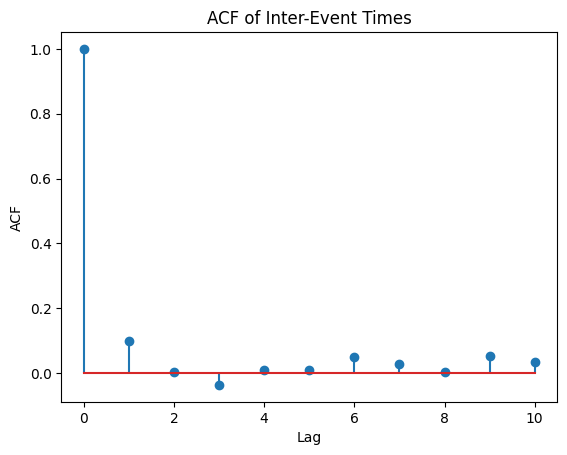

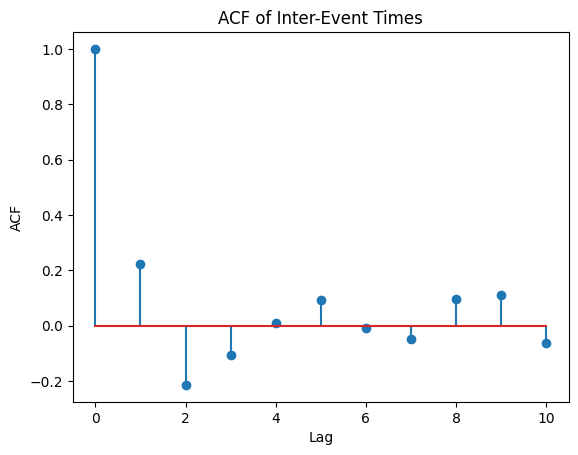

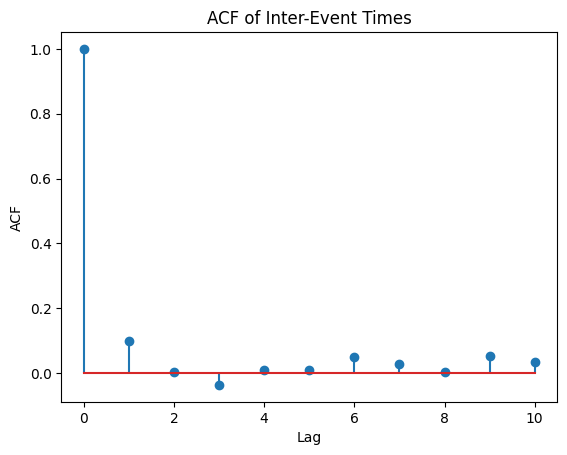

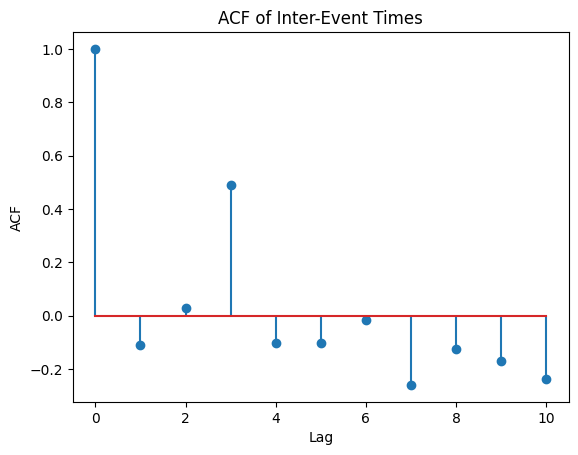

In [12]:
# 计算自相关函数（ACF）
def plot_acf(events, max_lag=10):  # 将max_lag从20减少到10
    if len(events) < 2:
        print("不足的事件数量来计算ACF")
        return
    
    intervals = np.diff(events)
    
    # 确保最大滞后不超过间隔序列长度
    max_lag = min(max_lag, len(intervals) - 1)
    
    if max_lag <= 0:
        print("不足的事件间隔来计算ACF")
        return
    
    acf_values = acf(intervals, nlags=max_lag, fft=True)
    plt.stem(range(max_lag+1), acf_values)
    plt.title("ACF of Inter-Event Times")
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.show()

# 使用更小的max_lag
plot_acf(events_periodic, max_lag=10)
plot_acf(events_poisson)     # ACF应接近零
plot_acf(events_periodic)    # ACF可能显示微弱周期
plot_acf(events_hawkes)      # ACF在短滞后上显著非零

通过KS检验判断是否符合泊松过程

In [ ]:
# 方法3：泊松过程检验（Kolmogorov-Smirnov）
def test_poisson(events):
    intervals = np.diff(events)
    from scipy.stats import kstest, expon
    ks_stat, p_value = kstest(intervals, expon.cdf, args=(1/np.mean(intervals),))
    print(f"KS检验p值: {p_value:.3f} (p>0.05接受泊松假设)")

通过STL分解检测周期性

In [ ]:
# 方法2：检测周期性（STL分解）
def detect_periodicity(events, period=10):
    counts, bins = np.histogram(events, bins=np.arange(0, T, 1))
    stl = STL(counts, period=period, seasonal=13)
    result = stl.fit()
    result.plot()
    plt.show()

通过拟合Hawkes模型检测自激励特性

In [ ]:
# 方法1：拟合Hawkes模型，检查参数显著性
def fit_hawkes(events):
    # 使用 'decays' 而不是 'decay'
    model = HawkesExpKern(decays=1.0)  # 注意这里是 decays (复数)
    model.fit(events)
    print(f"Hawkes模型参数 - 基线: {model.baseline[0]:.3f}, 自激强度: {model.adjacency[0,0]:.3f}")
    return model.score()  # 返回对数似然

=== Poisson Process ===
KS检验p值: 0.014 (p>0.05接受泊松假设)


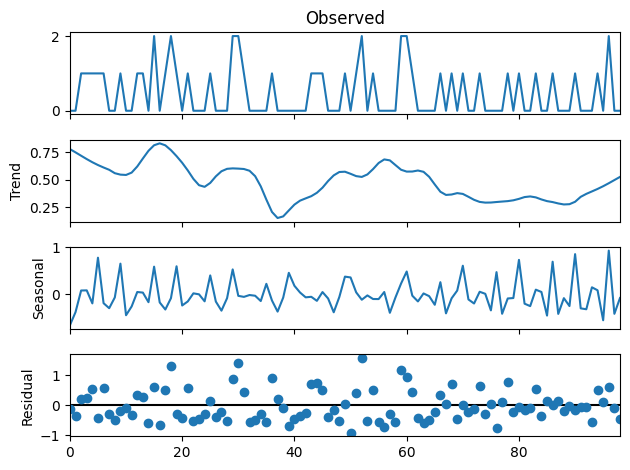


=== Periodic Poisson Process ===
KS检验p值: 0.000 (p>0.05接受泊松假设)


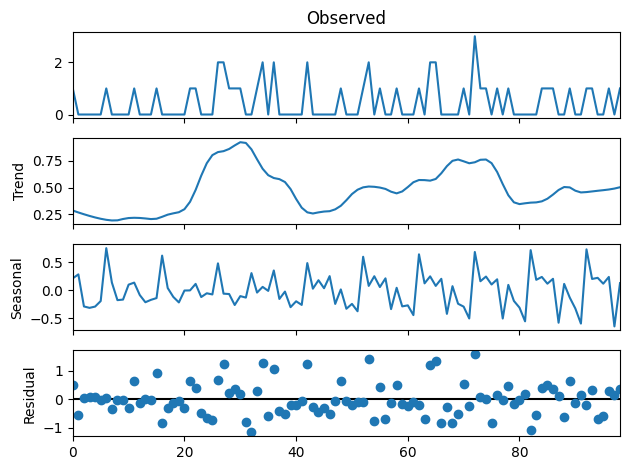


=== Hawkes Process ===
Hawkes模型参数 - 基线: 0.234, 自激强度: 0.166
KS检验p值: 0.007 (p>0.05接受泊松假设)


In [ ]:

print("=== Poisson Process ===")
test_poisson(events_poisson)
detect_periodicity(events_poisson)

print("\n=== Periodic Poisson Process ===")
test_poisson(events_periodic)  # 预期拒绝泊松假设
detect_periodicity(events_periodic)

print("\n=== Hawkes Process ===")
log_likelihood = fit_hawkes([events_hawkes])
test_poisson(events_hawkes)     # 预期拒绝泊松假设